In [2]:
import pandas as pd
from sklearn import preprocessing
import joblib
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


In [34]:
btvote = pd.read_pickle('../data/btvote_encoded.pkl')
btvote.head()

array(['CDU/CSU', 'SPD', 'Linke', 'FDP', 'GRÜNE', 'AfD'], dtype=object)

# Split data and encode target variable

In [4]:
# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Classification analysis

In [7]:
random_forest = joblib.load('./random_forest.joblib')

## Feature importance

In [9]:
feature_names = random_forest[1].get_feature_names_out()

# Sample feature importance vector (replace this with your actual data)
feature_importance_vector = random_forest[2].feature_importances_

# Create a dictionary to store aggregated importance for original features
original_feature_importance = {}

# Iterate over one-hot encoded features and their importance values
for encoded_feature, importance in zip(feature_names, feature_importance_vector):
    # Extract the original feature name
    original_feature = encoded_feature.split('_')[0]

    # Aggregate importance for original features
    if original_feature in original_feature_importance:
        original_feature_importance[original_feature] += importance
    else:
        original_feature_importance[original_feature] = importance

# Normalize importance values
total_importance = sum(original_feature_importance.values())
normalized_feature_importance = {feature: importance / total_importance for feature, importance in original_feature_importance.items()}

sorted_dict = dict(sorted(normalized_feature_importance.items(), key=lambda item: item[1], reverse=True))
print({x:y for x, y in sorted_dict.items()})
values = [y for x, y in sorted_dict.items()]
#plt.plot(values)

{'x39': 0.22151858828248402, 'x170': 0.16674195061130878, 'x26': 0.14635988338458877, 'x139': 0.1251736366250234, 'x159': 0.02516785705110843, 'x0': 0.020345027301054943, 'x1': 0.02006011794826629, 'x148': 0.01841574585051143, 'x223': 0.017675537145607025, 'x231': 0.01710391673641289, 'x230': 0.014781806130740675, 'x143': 0.014412806164530093, 'x236': 0.013465067269716116, 'x55': 0.012952567494874265, 'x37': 0.008592332755127326, 'x78': 0.00824035244581438, 'x12': 0.007865334636661796, 'x35': 0.007540173046192089, 'x234': 0.00689916081401014, 'x13': 0.006543093201858492, 'x154': 0.006335964012866458, 'x130': 0.006019165812223134, 'x168': 0.005766062487899633, 'x56': 0.005503968738449648, 'x240': 0.005068771210293165, 'x10': 0.0049278143401301185, 'x69': 0.00482515154137741, 'x65': 0.004525688580618898, 'x64': 0.004484868644401553, 'x199': 0.004351975281564836, 'x198': 0.004312590889876469, 'x9': 0.004223976008577638, 'x241': 0.004059710274910734, 'x162': 0.003922263436536379, 'x243': 0

# Training with the subset

In [58]:
subset_data = btvote_data.iloc[:, [58, 194, 56, 36, 169, 30, 160, 60, 29, 39]]

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
X = subset_data.values
y = btvote_target

imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X = encoder.fit_transform(X)


0.05241983901463743

In [23]:
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

accuracy_per_fold = []
f1_per_fold = []

roc_auc_scores = []
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for i, (train_index, test_index) in enumerate(stratified_10_fold_cv.split(subset_data, btvote_target)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    tree = RandomForestClassifier(criterion='entropy', max_depth=30, random_state=42)
    tree.fit(X_train, y_train)

    acc = tree.score(X_test, y_test)
    accuracy_per_fold.append(acc)

    f1 = f1_score(y_test, tree.predict(X_test), average='macro')
    f1_per_fold.append(f1)

print(sum(accuracy_per_fold)/len(accuracy_per_fold))
print(sum(f1_per_fold) / len(f1_per_fold))

/Users/david/PycharmProjects/btvote/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
from itertools import cycle
from sklearn.preprocessing import label_binarize

y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], tree.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), tree.predict_proba(X_test).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(np.unique(y))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=4, label='Micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.7436576576576576
F1 Score: 0.7446272616038427


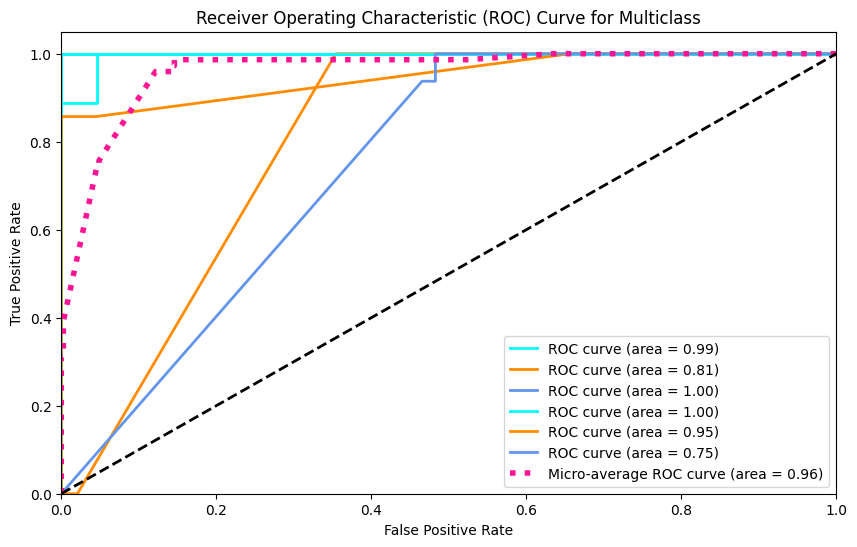

In [25]:
tree = RandomForestClassifier(criterion='entropy', max_depth=30, random_state=42)
tree.fit(X,y)
joblib.dump(tree, "tree.joblib")

Accuracy: 0.7423423423423424
F1 Score: 0.7425840749260684
